In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


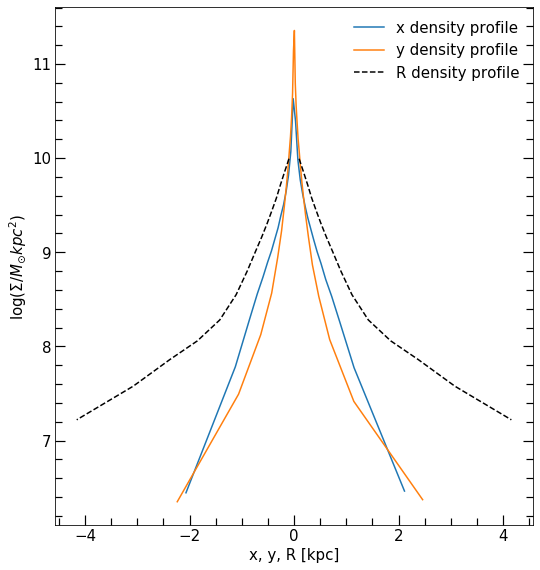

In [9]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint
import numpy as np
import matplotlib.pyplot as plt
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
aa = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = aa[:,2]

# snapshot=range(496,300,-1) #SNAPSHOTS

path = '/mnt/is2/alejandro/ornella/'

# for isnap in snapshot:

isnap=496

halos = (0,1,3)

# for i in halos:
i=0
snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]

pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

z     = a0/aexp[isnap] - 1.
Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
r    = np.sqrt(xstr**2+ystr**2+zstr**2)

#paso las velocidades a unidades físicas
v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

mstr = mstr/h     #masa a unidades físicas

r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

rgal = 0.15*r200          #defino el radio de la galaxia

limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
razon = Mc_str/Mgal 
noventa, = np.where(razon < 0.9)
cincuenta, = np.where(razon < 0.5)

r90 = r_sort[noventa][-1]   #radio a 90% la masa
r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#componentes de la velocidad del centro de masa
veloc, = np.where(r < r50)

vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
vx = v_x - vxcm
vy = v_y - vycm
vz = v_z - vzcm

#-------------------------------------------------------------------------------------
#hago la rotación de las coordenadas respecto del momento angular    
e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

xn = e1x*xstr + e1y*ystr + e1z*zstr
yn = e2x*xstr + e2y*ystr + e2z*zstr
zn = e3x*xstr + e3y*ystr + e3z*zstr
vxn = e1x*vx + e1y*vy + e1z*vz
vyn = e2x*vx + e2y*vy + e2z*vz
vzn = e3x*vx + e3y*vy + e3z*vz

corte, = np.where(r < 6.)

A2max, rmax, phimax = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)

xx = xn*np.cos(phimax)  + yn*np.sin(phimax)
yy = xn*-np.sin(phimax) + yn*np.cos(phimax)
zz = zn

R = np.sqrt(xx**2 + yy**2)

cortex, = np.where((r<5) & (yy<0.5) & (yy>-0.5))
cortey, = np.where((r<5) & (xx<0.5) & (xx>-0.5))
corteR, = np.where((r<5))


nbin = 30
x_profile, medx = density.surf_density(xx[cortex],mstr[cortex]*1e10,30)    
y_profile, medy = density.surf_density(yy[cortey],mstr[cortey]*1e10,30)
R_profile, medR = density.surf_density(R[corteR], mstr[corteR]*1e10,15)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)
ax.plot(medx, np.log10(x_profile), color='tab:blue', label='x density profile')    
ax.plot(medy, np.log10(y_profile), color='tab:orange', label='y density profile')    
ax.plot(medR, np.log10(R_profile), color='k', ls='--', label='R density profile')
ax.plot(-medR, np.log10(R_profile),color='k', ls='--')
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax.set_ylabel('log($\Sigma$/$M_{\odot}kpc^2$)',fontsize=15)
ax.set_xlabel('x, y, R [kpc]',fontsize=15)
ax.legend(fontsize=15,frameon=False)

plt.show()

/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log10
/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in log10


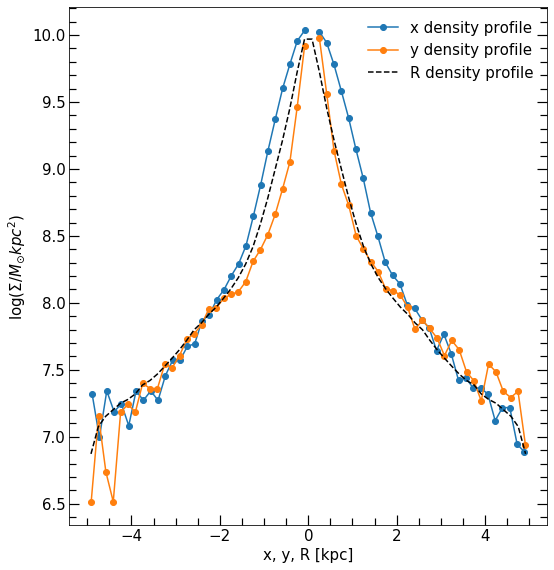

In [2]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint
import numpy as np
import matplotlib.pyplot as plt
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
aa = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = aa[:,2]

# snapshot=range(496,300,-1) #SNAPSHOTS

path = '/mnt/is2/alejandro/ornella/'

# for isnap in snapshot:

isnap=496

halos = (0,1,3)

# for i in halos:
i=0
snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]

pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

z     = a0/aexp[isnap] - 1.
Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
r    = np.sqrt(xstr**2+ystr**2+zstr**2)

#paso las velocidades a unidades físicas
v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

mstr = mstr/h     #masa a unidades físicas

r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

rgal = 0.15*r200          #defino el radio de la galaxia

limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
razon = Mc_str/Mgal 
noventa, = np.where(razon < 0.9)
cincuenta, = np.where(razon < 0.5)

r90 = r_sort[noventa][-1]   #radio a 90% la masa
r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#componentes de la velocidad del centro de masa
veloc, = np.where(r < r50)

vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
vx = v_x - vxcm
vy = v_y - vycm
vz = v_z - vzcm

#-------------------------------------------------------------------------------------
#hago la rotación de las coordenadas respecto del momento angular    
e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

xn = e1x*xstr + e1y*ystr + e1z*zstr
yn = e2x*xstr + e2y*ystr + e2z*zstr
zn = e3x*xstr + e3y*ystr + e3z*zstr
vxn = e1x*vx + e1y*vy + e1z*vz
vyn = e2x*vx + e2y*vy + e2z*vz
vzn = e3x*vx + e3y*vy + e3z*vz

corte, = np.where(r < 6.)

A2max, rmax, phimax = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)

xx = xn*np.cos(phimax)  + yn*np.sin(phimax)
yy = xn*-np.sin(phimax) + yn*np.cos(phimax)
zz = zn

R = np.sqrt(xx**2 + yy**2)

corte, = np.where(r<5)

nbin = 30
x_profile, medx = density.surf_density_x(xx[corte],yy[corte],mstr[corte]*1e10,30)    
y_profile, medy = density.surf_density_x(yy[corte],xx[corte],mstr[corte]*1e10,30)
R_profile, medR = density.surf_density2(R[corte], mstr[corte]*1e10,30)

RR  = np.concatenate([-medR[::-1],medR])
Rpf = np.concatenate([R_profile[::-1],R_profile])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)
ax.plot(medx, np.log10(x_profile), 'o-',color='tab:blue', label='x density profile')    
ax.plot(medy, np.log10(y_profile), 'o-',color='tab:orange', label='y density profile')    
ax.plot(RR, np.log10(Rpf), color='k', ls='--', label='R density profile')
# ax.plot(-medR, np.log10(R_profile),color='k', ls='--')
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax.set_ylabel('log($\Sigma$/$M_{\odot}kpc^2$)',fontsize=15)
ax.set_xlabel('x, y, R [kpc]',fontsize=15)
ax.legend(fontsize=15,frameon=False)

plt.show()

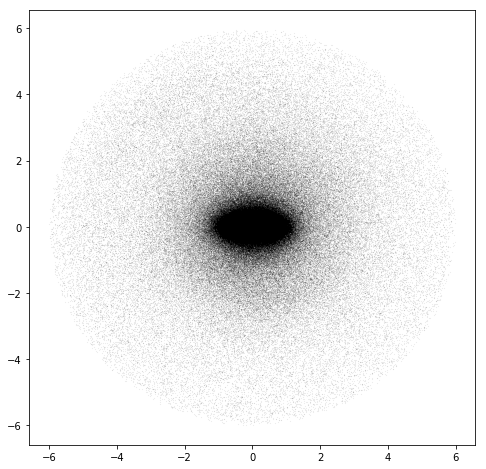

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.plot(xx[corte],yy[corte],'.k',markersize=0.0)

In [55]:
RR = R[corte2]
nodos = np.linspace(RR.min(),RR.max(),11)

width = (RR.max()-RR.min())/10

med = np.linspace(RR.min()+width/2., RR.max()-width/2., 10)

NameError: name 'corte2' is not defined

In [53]:
print nodos, len(nodos)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] 11


In [54]:
print med, len(med)

[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5] 10


In [51]:
print width

1
